In [1]:
#!pip install timm
# !pip install opencv-python

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision
from torchvision import transforms
# import timm
from timm import create_model

import cv2
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt

### Dataset
Repurposed code from MobileNet model notebook. Changes made include directory reference to content folder, and the keep.csv is already filterd to the classes we wanted to keep.

In [3]:
# Class list
# uploaded class_list to colab session -- todo: revise for local usage
class_list_path = r"C:\Users\linay\Downloads\ifood-2019-fgvc6\class_list.txt"

class_mapping = {}

# Open the file and read the contents
with open(class_list_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        # Split each line by space to separate the index and the class name
        index, class_name = line.strip().split(' ', 1)
        # Convert the index to an integer and add the mapping to the dictionary
        class_mapping[int(index)] = class_name
    print(class_mapping.values())

dict_values(['macaron', 'beignet', 'cruller', 'cockle_food', 'samosa', 'tiramisu', 'tostada', 'moussaka', 'dumpling', 'sashimi', 'knish', 'croquette', 'couscous', 'porridge', 'stuffed_cabbage', 'seaweed_salad', 'chow_mein', 'rigatoni', 'beef_tartare', 'cannoli', 'foie_gras', 'cupcake', 'osso_buco', 'pad_thai', 'poutine', 'ramen', 'pulled_pork_sandwich', 'bibimbap', 'chicken_kiev', 'apple_pie', 'risotto', 'fruitcake', 'chop_suey', 'haggis', 'scrambled_eggs', 'frittata', 'scampi', 'sushi', 'orzo', 'fritter', 'nacho', 'beef_stroganoff', 'beef_wellington', 'spring_roll', 'savarin', 'crayfish_food', 'souffle', 'adobo', 'streusel', 'deviled_egg', 'escargot', 'club_sandwich', 'carrot_cake', 'falafel', 'farfalle', 'terrine', 'poached_egg', 'gnocchi', 'bubble_and_squeak', 'egg_roll', 'caprese_salad', 'sauerkraut', 'creme_brulee', 'pavlova', 'fondue', 'scallop', 'jambalaya', 'tempura', 'chocolate_cake', 'potpie', 'spaghetti_bolognese', 'sukiyaki', 'applesauce', 'baklava', 'salisbury_steak', 'lin

In [4]:
# Reduce classes after EDA process
keep_list = r"C:\Users\linay\Downloads\ifood-2019-fgvc6\keep.csv"
df_keep = pd.read_csv(keep_list)
## commenting out the below code because I already filtered the csv file to all of the classes we wanted to keep
# df_keep = df_keep[df_keep['All Agree']=='True']
print("Classes to train for :", len(df_keep))
classes_to_keep = df_keep['category_name'].tolist()

Classes to train for : 26


In [5]:
# Convert to an array of label IDs for classes to keep
filtered_class_mapping = {index: class_name for index, class_name in class_mapping.items() if class_name in classes_to_keep}
print("Filtered class mapping:", len(filtered_class_mapping))
filtered_class_ids = list(map(str, filtered_class_mapping.keys()))

Filtered class mapping: 26


In [6]:
# Check "bad" input test data, and return only those that are good
type_1_data = pd.read_csv(r"C:\Users\linay\Downloads\ifood-2019-fgvc6\df_eda.csv")
type_1_data = type_1_data[(type_1_data['is_cartoon'] == False) & (type_1_data['has_face'] == False) & (type_1_data['is_media_art'] == False) & (type_1_data['has_text'] == False)]
type_1_data = type_1_data['img_name'].to_list()
print("count of good data:", len(type_1_data))

count of good data: 40631


In [7]:
# Paths to the dataset
train_dir = r"C:\Users\linay\Downloads\ifood-2019-fgvc6\train_set\train_set"
val_dir   = r"C:\Users\linay\Downloads\ifood-2019-fgvc6\val_set\val_set"
test_dir  = r"C:\Users\linay\Downloads\ifood-2019-fgvc6\test_set\test_set"

# Path to the labels
df_train = pd.read_csv(r"C:\Users\linay\Downloads\ifood-2019-fgvc6\train_labels.csv")
df_val   = pd.read_csv(r"C:\Users\linay\Downloads\ifood-2019-fgvc6\val_labels.csv")

# TypeError: If class_mode="categorical", y_col="label" column values must be type string, list or tuple.
df_train['label'] = df_train['label'].astype(str)
df_val['label']   = df_val['label'].astype(str)

# Filter datasets to just classifications of interest
df_train = df_train[df_train['label'].isin(filtered_class_ids)]
print("This is the number of images that are in the filtered class in train set:", len(df_train))
df_train = df_train[df_train['img_name'].isin(type_1_data)]
print("This is the number of images that are in the the filtered class and also are not bad images in train set:", len(df_train))
df_val   = df_val[df_val['label'].isin(filtered_class_ids)]

This is the number of images that are in the filtered class in train set: 13988
This is the number of images that are in the the filtered class and also are not bad images in train set: 5772


In [8]:
# append a new column and store the image directory in the columns
df_train['image_directory'] = ''
for index, row in df_train.iterrows():
    df_train.loc[index, 'image_directory'] = os.path.join(train_dir, row['img_name']) 

# change the labels to integer 
df_train['label'] = df_train['label'].astype(int)

# append a new column and store the image directory in the colums 
df_val['image_directory'] = ''
for index, row in df_val.iterrows():
    df_val.loc[index, 'image_directory'] = os.path.join(val_dir, row['img_name']) 

df_val['label'] = df_val['label'].astype(int)

In [9]:
# # CUTE DELETE LATER
# # Remove the images that we want to keep for classification 
# # Create a new folder to store the filtered dataset 
# # Identify the images for just classification interest 
# image_names = df_train['img_name'].tolist()
# print("number of images for training", len(image_names)) 
# # instantiate an empty list to store matched images 
# matched_image_directory = []

# # iterate through the file names and check if each image exists in the directory 
# count = 0
# for image in image_names:
#     curr_train_dir = os.path.join(train_dir, image)
#     # testing current image train_dir (setting curr_train_dir for EACH image, using global train_dir variable)
#     # if (count < 5):
#     #     print(curr_train_dir)
#     #     count += 1
#     if os.path.exists(train_dir):
#         matched_image_directory.append(train_dir)
# # print or use the list of matched images
# print("number of images in the directory:", len(matched_image_directory))

In [10]:
# # CUTE DELETE LATER
# create the destination directory to store all of the filtered,clean images
# new_train_dir = r"C:\Users\linay\Downloads\ifood-2019-fgvc6\train_set\train_set_filtered"
# if not os.path.exists(new_train_dir):
#     os.makedirs(new_train_dir)
    
# if os.path.exists(new_train_dir):
#     for filename in os.listdir(new_train_dir): 
#         file_path = os.path.join(new_train_dir, filename)
#         if os.path.isfile(file_path):
#             os.remove(file_path)
#             # print(f"Deleted file: {file_path}")

# for image in image_names:
#     src_file_path = os.path.join(train_dir, image)
#     # print(src_file_path)
#     if os.path.exists(src_file_path):
#         shutil.copy2(src_file_path, new_train_dir)
#         # print(f"Copied {file_name} to {new_train_dir}")

### Create and Evaluate Model

In [11]:
# Load training dataset and create data loader

# takes the df_train pandas dataframe 
# and transforms as inputs and returns the image along with corresponding label
class CustomImageDataset(Dataset): 
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.df.iloc[index, 2]  # assuming the image path is in the 3 column
        label = self.df.iloc[index, 1]  # assuming the label is in the second column
        image = Image.open(image_path)
        image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# create training data set and data loader
data_set = CustomImageDataset(df_train, transform)
data_loader = DataLoader(data_set, batch_size=32, shuffle=True)

# create validation dataset and data loader
validation_data_set = CustomImageDataset(df_val, transform)
validation_data_loader = DataLoader(validation_data_set, batch_size=32, shuffle=False)

In [13]:
# Load pre-trained DeiT model
model = create_model('deit_base_patch16_224', pretrained=True)

# Train the model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Instantiate lists to store training and validation loss and accuracy
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# create a function to evaluate the model on the validation set 
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
    accuracy = total_correct / len(data_loader.dataset)
    return total_loss / len(data_loader), accuracy

# instantiate the patience count and minimum delta
patience = 10
min_delta = 0.000001

best_val_loss = float('inf')
patience_count = 0

for epoch in range(100):
    total_loss = 0 
    total_correct = 0
    for images, labels in data_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.squeeze())

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
    
    # Calculate training loss and accuracy
    train_loss.append(total_loss / len(data_loader))
    train_accuracy.append(total_correct / len(data_loader.dataset))

    
    # evaluate the model on the validation set
    model.eval()
    validation_loss, validation_accuracy = evaluate(model, validation_data_loader)
    val_loss.append(validation_loss)
    val_accuracy.append(validation_accuracy)

    # check to see if validation loss has improved 
    # stop if plateaus 
    if validation_loss < best_val_loss - min_delta:
        best_val_loss = validation_loss
        patience_count = 0
    else:
        patience_count += 1

    if patience_count >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break    

    # print loss and accuracy for each epoch 
    print('Epoch {}: Loss = {:.4f}, Validation Loss = {:.4f}, Validation Accuracy = {:.4f}'.format(epoch+1, loss.item(), validation_loss, validation_accuracy))

Epoch 1: Loss = 2.4813, Validation Loss = 2.6160, Validation Accuracy = 0.2220
Epoch 2: Loss = 1.3486, Validation Loss = 2.2389, Validation Accuracy = 0.3379
Epoch 3: Loss = 2.4105, Validation Loss = 2.0364, Validation Accuracy = 0.3966
Epoch 4: Loss = 1.4409, Validation Loss = 2.1213, Validation Accuracy = 0.3608
Epoch 5: Loss = 1.7308, Validation Loss = 2.0988, Validation Accuracy = 0.3677
Epoch 6: Loss = 1.2878, Validation Loss = 1.9435, Validation Accuracy = 0.4180
Epoch 7: Loss = 0.7915, Validation Loss = 2.0224, Validation Accuracy = 0.4195
Epoch 8: Loss = 1.7314, Validation Loss = 1.8997, Validation Accuracy = 0.4348
Epoch 9: Loss = 0.8561, Validation Loss = 2.0754, Validation Accuracy = 0.4188
Epoch 10: Loss = 0.8662, Validation Loss = 2.2820, Validation Accuracy = 0.4241
Epoch 11: Loss = 0.8350, Validation Loss = 2.1602, Validation Accuracy = 0.4088
Epoch 12: Loss = 0.6879, Validation Loss = 2.3239, Validation Accuracy = 0.4157
Epoch 13: Loss = 0.9556, Validation Loss = 2.4666

In [17]:
# save scores to csv 
def save_scores_to_csv(train_loss, train_accuracy, val_loss, val_accuracy, filename): 
    '''
    stores train and validation loss and accuracy into a csv
    '''
    # create a dictionary to store the scores
    scores = {
        'Epoch': range(1, len(train_loss) + 1),
        'Train Loss': train_loss,
        'Train Accuracy': train_accuracy,
        'Val Loss': val_loss,
        'Val Accuracy': val_accuracy
    }
    
    # convert the dictionary to a DataFrame
    df = pd.DataFrame(scores)
    
    # save the DataFrame to a csv file
    df.to_csv(filename, index=False)

In [18]:
# call the save score function to save my scores 
save_scores_to_csv(train_loss, train_accuracy, val_loss, val_accuracy,'scores.csv')

In [28]:
def training_validation_loss_accuracy_plots(csv_file): 
    '''
    take the csv file and transform the pandas dataframe
    plot training and validation loss and accuracy 
    '''
    df = pd.read_csv(csv_file) 
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(df['Epoch'], df['Train Loss'], label='Training Loss')
    plt.plot(df['Epoch'], df['Val Loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(range(1, len(df['Epoch']) + 1)) 
    
    plt.subplot(1, 2, 2)
    plt.plot(df['Epoch'], df['Train Accuracy'], label='Training Accuracy')
    plt.plot(df['Epoch'], df['Val Accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(1, len(df['Epoch']) + 1)) 

    plt.suptitle('Training and Validation Metrics')
    plt.show()

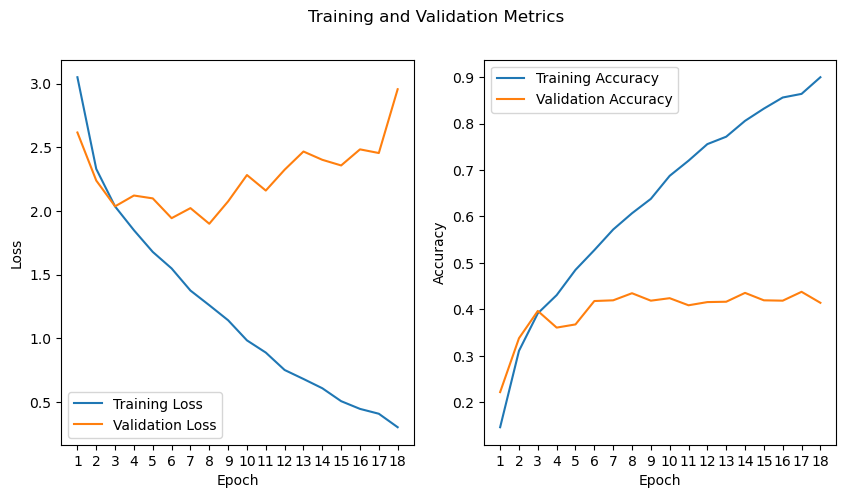

In [29]:
# call the loss accuracy plot function 
training_validation_loss_accuracy_plots('scores.csv')